# Recurrent Neural Network

### Contents
    1. Introduction
    2. Import Libraries
    3. Dataset with Ethereum (Bitcoin) Historical Data
    4. Build Recurrent Neural Network Models
    5. Train the Model
    6. Test the Model
    7. Save the Model
    8. References

## 1. Introduction

When human read a text, they understand each word based on the previous words, not from scratch for each word. This can be called **memory**. Convolutional Neural Network models (CNNs) cannot implement this concept of **memory** thus Recurrent Neural Network models (RNNs) are introduced to address this problem. They are networks with loops in them, allowing information to persist (memory).
![VanillaRNN](./Images/VanillaRNN.png)

If this model is unrolled, it can be considered as multiple copies of the same network, each of them passing information to next. In other words, The first RNN is receiving input vectors and the second RNN is receiving the output of the first RNN and passing its output to the third RNN. 
![UnrolledVanillaRNN](./Images/UnrolledVanillaRNN.png)


Its variant diagrams and corresponding applications are described below.
![Application](./Images/RNNapplication.png)

The applications of RNN are, 
- Words in image caption (one to many)
- Sentiment analysis (many to one, sequence input)
- Machine translation (many to many, sequence input and sequence output)
- Speech recognition (many to many)

It is widely used for processing sequencial data for predictions and natural language processing. As Vanilla RNN is suffering from short-term memory (gradient vanishing problem), LSTM and GRU are introduced to resolve this issue. Especially LSTM is widely adopted to deep learning models. 

This notebook covers how variants of RNN can be implemented via PyTorch and apply them to BitCoin price prediction.

## 2. Import Libraries
Import the packages that are necessary for implementing recurrent neural network. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as Data
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(torch.__version__)

1.1.0


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 3. Dataset with Ethereum (Bitcoin) Historical Data

Time-series data, not language data, will be handled by comparing performance of variants of RNN.The data will be used is from [Kaggle Ethereum Historical Data](https://www.kaggle.com/kingburrito666/ethereum-historical-data). Ehtereum blockchain is a kind of cryptocurrency.

In [4]:
data = pd.read_csv("./data/EtherPriceHistory(USD).csv")
data.tail()

,Date(UTC),UnixTimeStamp,Value
1159,10/1/2018,1538352000,230.89
1160,10/2/2018,1538438400,225.41
1161,10/3/2018,1538524800,219.97
1162,10/4/2018,1538611200,221.76
1163,10/5/2018,1538697600,227.90


In [5]:
data.isnull().sum()

Date(UTC)        0
UnixTimeStamp    0
Value            0
dtype: int64

No data is missing so don't have to drop null data.

In [6]:
len(data)

1164

So we have data length of 1164. Then I will plot the data to see the trend of bitcoin price. 

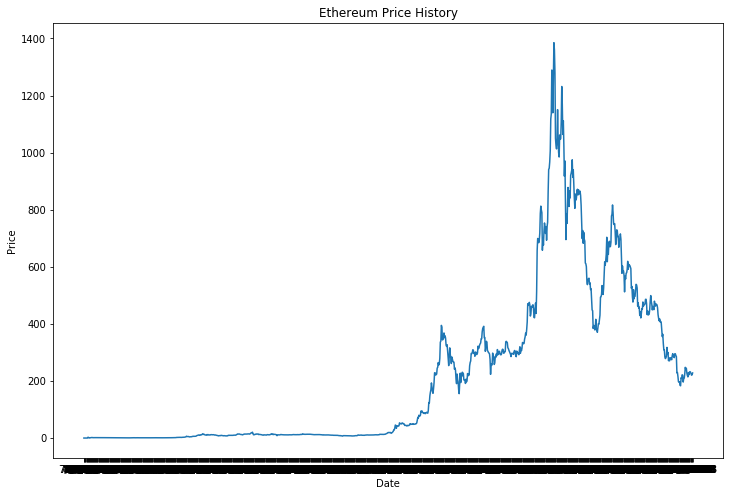

In [7]:
plt.figure(figsize = (12, 8))
plt.plot(data["Date(UTC)"], data["Value"])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Ethereum Price History")
plt.show()

In [8]:
# Hyper parameters
threshold = 116
window = 30

input_size = 1
hidden_size = 50
num_layers = 3
output_size = 1

learning_rate = 0.001
batch_size = 16

In [9]:
train_data = data['Value'][:len(data) - threshold]
test_data = data['Value'][len(data) - threshold:]

len(train_data), len(test_data)

(1048, 116)

Shuffling training data is not desired choice. The below function is make a sliding window that sweeps through all the training data. It extracts the feature of tendency.

In [10]:
def create_sequences(input_data, window):
    length = len(input_data)
    
    x = input_data[0:window].values
    y = input_data[1:window+1].values
    
    for i in range(1, length - window):
        x = np.vstack((x, input_data[i:i+window].values))
        y = np.vstack((y, input_data[i+1:window+1+i].values))
        
        sequence = torch.from_numpy(x).type(torch.FloatTensor)
        label = torch.from_numpy(y).type(torch.FloatTensor)
        
        sequence = Data.TensorDataset(sequence, label)
        
    return sequence

In [11]:
train_data = create_sequences(train_data, window)

In [12]:
train_loader = Data.DataLoader(train_data, 
                               batch_size = batch_size, 
                               shuffle = False, 
                               drop_last = True)

## 4. Build Recurrent Neural Network Model
I will implement three variants of RNNs, Vanilla RNN, LSTM and GRU.
### 4.1 Vanilla RNN

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.hidden = torch.zeros(num_layers, 1, hidden_size)
        
        self.rnn = nn.RNN(input_size, 
                          hidden_size, 
                          num_layers,             # number of recurrent layers
                          batch_first = True,    # Default: False
                                                  # If True, layer does not use bias weights
                          nonlinearity = 'relu',  # 'tanh' or 'relu'
                          #dropout = 0.5
                         )
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # input shape of (batch, seq_len, input_size)
        # output shape of (batch, seq_len, hidden_size)
        out, hidden = self.rnn(x, self.hidden)
        self.hidden = hidden
        
        # output shape of (batch_, seq_len, output_size)
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size):
        # hidden shape of (num_layers, batch, hidden_size)
        self.hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [14]:
rnn = RNN(input_size, hidden_size, num_layers, output_size).to(device)

In [15]:
rnn

RNN(
  (rnn): RNN(1, 50, num_layers=3, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

### 4.2 LSTM
Recurrent Neural Networks (Vanilla RNNs) are very forgetful and they are ineffective when it comes to long-term memory. In other words, the issue of gradient vanishing arises in RNN. Thus, Long Short Term Memory (LSTMs) are introduced to overcome this weakness, not being to preserve errors backpropagated through time and layers. Detailed description on how LSTM works is written [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) but you don't have to know its process to implement and exploit LSTM. 
![LSTM](./Images/LSTM.png)

Related Paper is [Long Short-Term Memory](https://www.bioinf.jku.at/publications/older/2604.pdf).

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.hidden = torch.zeros(num_layers, 1, hidden_size)
        
        self.lstm = nn.LSTM(input_size, 
                            hidden_size, 
                            num_layers, 
                            batch_first = True, 
                            bidirectional = False, 
                            dropout = 0.3)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Set initial hidden and cell states
        out, (hidden, cell) = self.lstm(x, (self.hidden, self.cell))
        self.hidden = hidden
        self.cell = cell
        
        #out, (hidden, cell) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size):
        self.hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        self.cell = torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [17]:
lstm = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

In [18]:
lstm

LSTM(
  (lstm): LSTM(1, 50, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

### 4.3 GRU
GRU, Gradient Recurrent Unit, is a newer version of Recurrent Neural Network models and similar to LSTM. It just removed the cell state and used the hidden state to process information. Thus, it has only two gates, a reset gate and update gate. The information on how GRU networks work is described [here](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be).
![GRU](./Images/GRU.png)

Related paper is [Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling](https://arxiv.org/pdf/1412.3555.pdf).

In [19]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.hidden = torch.zeros(num_layers, 1, hidden_size)
        
        self.gru = nn.GRU(input_size, 
                          hidden_size, 
                          num_layers, 
                          batch_first = True, 
                          bidirectional = False, 
                          dropout = 0.2)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Set initial hidden and cell states
        out, hidden = self.gru(x, self.hidden)
        self.hidden = hidden
        
        #out, (hidden, cell) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size):
        self.hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [20]:
gru = GRU(input_size, hidden_size, num_layers, output_size).to(device)

In [21]:
gru

GRU(
  (gru): GRU(1, 50, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

## 5. Train the Model

`MSELoss` means Mean Squared Loss and `Adam` means Adam Optimizer with learning rate of 0.001. Different from training of CNN model, I added `nn.utils.clip_grad_norm_` to prevent gradient exploding problem. 

In [22]:
def train(model, num_epochs):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    for epoch in range(num_epochs):

        for i, (sequences, labels) in enumerate(train_loader):

            model.init_hidden(batch_size)

            sequences = sequences.view(-1, window, 1)
            labels = labels.view(-1, window, 1)
            
            pred = model(sequences)
            cost = criterion(pred[-1], labels[-1])
            
            optimizer.zero_grad()
            cost.backward()
            
            # prevent gradient exploding problem
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            optimizer.step()
    
        print("Epoch [%d/%d] Loss %.4f"%(epoch+1, num_epochs, cost.item()))
    
    print("Training Finished!")

In [23]:
train(rnn, 150)

Epoch [1/150] Loss 22865.6816
Epoch [2/150] Loss 2311.3613
Epoch [3/150] Loss 4580.8110
Epoch [4/150] Loss 1107.7328
Epoch [5/150] Loss 1281.5402
Epoch [6/150] Loss 2751.8538
Epoch [7/150] Loss 2305.1577
Epoch [8/150] Loss 4213.8809
Epoch [9/150] Loss 2762.3000
Epoch [10/150] Loss 1200.9888
Epoch [11/150] Loss 1001.3839
Epoch [12/150] Loss 1148.1423
Epoch [13/150] Loss 950.5982
Epoch [14/150] Loss 1991.4315
Epoch [15/150] Loss 1997.9072
Epoch [16/150] Loss 1326.9019
Epoch [17/150] Loss 1105.4576
Epoch [18/150] Loss 1558.2930
Epoch [19/150] Loss 2238.4297
Epoch [20/150] Loss 1352.3623
Epoch [21/150] Loss 1291.0302
Epoch [22/150] Loss 1447.6685
Epoch [23/150] Loss 1271.8508
Epoch [24/150] Loss 1048.0983
Epoch [25/150] Loss 1700.5388
Epoch [26/150] Loss 1034.2921
Epoch [27/150] Loss 2475.5317
Epoch [28/150] Loss 2378.2297
Epoch [29/150] Loss 1414.8904
Epoch [30/150] Loss 1883.5282
Epoch [31/150] Loss 1270.7339
Epoch [32/150] Loss 2870.8228
Epoch [33/150] Loss 2505.8184
Epoch [34/150] Loss

## 6. Test the Model

In [26]:
def evaluation(model):
    model.eval()
    model.init_hidden(1)
    
    val_day = 30
    dates = data['Date(UTC)'][1049+window:1049+window+val_day]
    
    pred_X = []
    
    for i in range(val_day):
        X = torch.from_numpy(test_data[i:window+i].values).type(torch.FloatTensor)
        X = X.view(1, window, 1).to(device)

        pred = model(X)
        pred = pred.reshape(-1)
        pred = pred.cpu().data.numpy()

        pred_X.append(pred[-1])

    y = test_data[window:window+val_day].values
    
    plt.figure(figsize = (12, 8))
    plt.plot(dates, y, 'o-', alpha = 0.7, label = 'Real')
    plt.plot(dates, pred, '*-', alpha = 0.7, label = 'Predict')
    
    plt.xticks(rotation = 45)
    plt.xlabel("Date")
    plt.ylabel("Ethereum Price (USD)")
    plt.legend()
    
    plt.title("Comparison between Prediction and Real Ethereum BitCoin Price")
    plt.show()

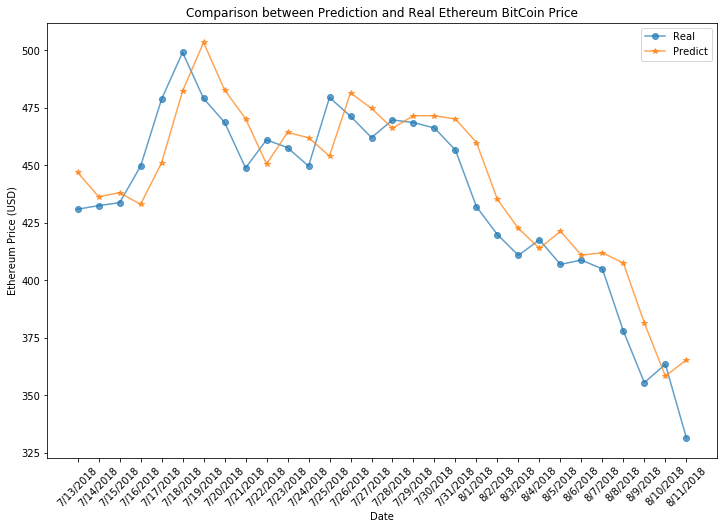

In [27]:
evaluation(rnn)

The predicted price roughly follows the tendency of price change but the absolute value of price differs a bit from real price. However, considering the huge variation of price, its prediction is not really bad. It can be improved by modifying model paramters and hyper parameters.

## 7. Save the Model
We may need to save the model for future use.

In [28]:
# Save the model checkpoint
save_path = './model/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

torch.save(rnn.state_dict(), 'rnn.ckpt')

## 8. Further References
- [A Beginner’s Guide on Recurrent Neural Networks with PyTorch](https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/)
- [Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
- [Predict Bitcoin price with LSTM](https://sergioskar.github.io/Bitcon_prediction_LSTM/)